# Loading pyqg Data

The pyqg forcing data is stored in a zarr file format, which we use the zarr Python package to open, using the code below

In [10]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import os
import fsspec
from pydmd import DMD, BOPDMD
from pydmd.plotter import plot_eigs, plot_summary
from pydmd.preprocessing import hankel_preprocessing
from pydmd.plotter import plot_modes_2D

In [2]:
data_root_directory = "/scratch/nad9961/GFD_data/publication"

# Directory with low-res jet configuration
lowres_jet_directory = "jet/low_res.zarr"
highres_jet_directory = "jet/high_res.zarr"

# The consolidated option tells us to look at the metadata
lowres_jet_data = xr.open_zarr(os.path.join(data_root_directory, lowres_jet_directory), consolidated=True)
highres_jet_data = xr.open_zarr(os.path.join(data_root_directory, highres_jet_directory), consolidated=True) 

We can also load the data from a global data source

We can examine the structure of the data using the `info` attribute

Let's look at how the potential vorticity q is stored

## Plotting vorticity data

The data in the run is stored in five dimensions (run number, layer, time, x, y)

Let's look at the PV for first run

Text(0, 0.5, 'y [m]')

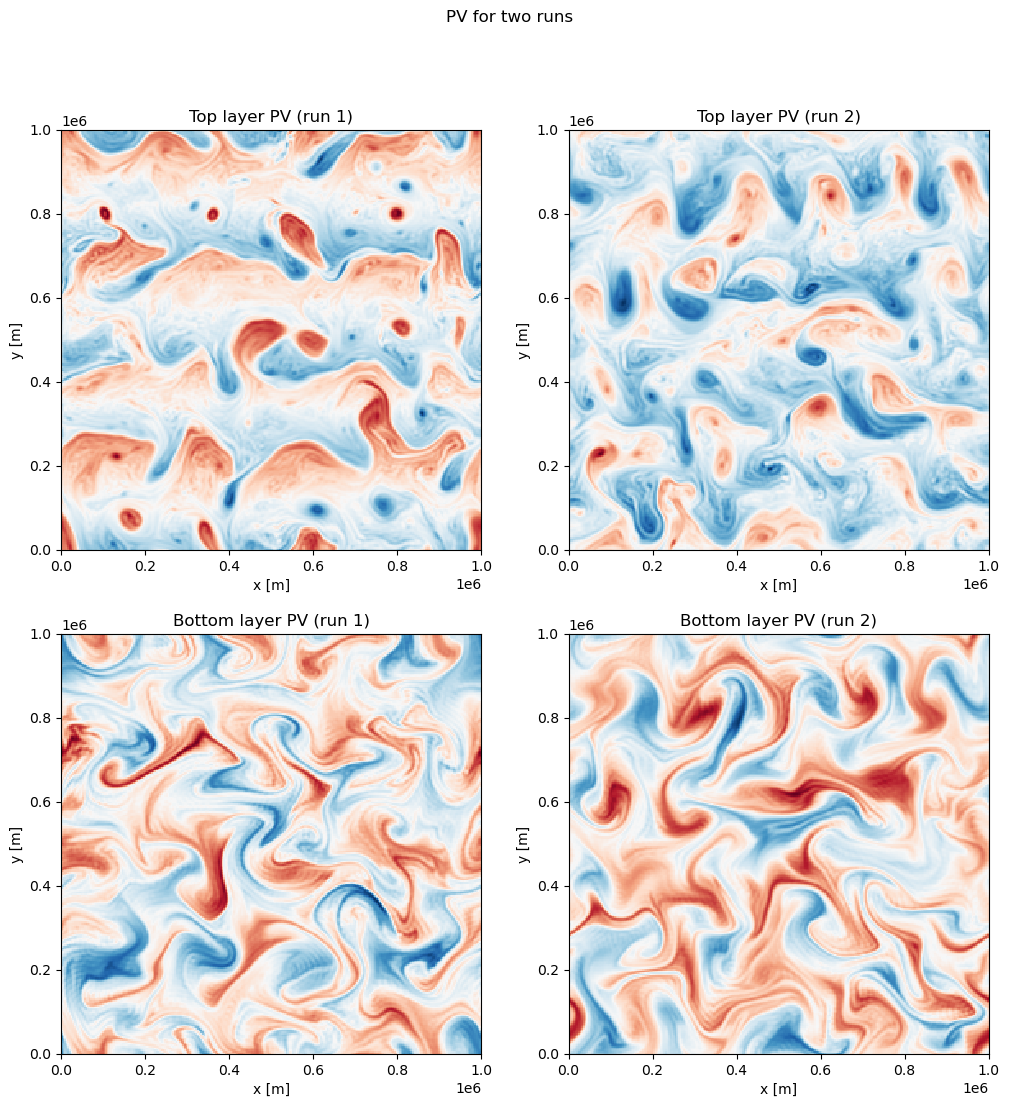

In [5]:
plot_data = highres_jet_data

fig = plt.figure(figsize=(12,12))
plt.suptitle("PV for two runs")
plt.set_cmap('RdBu')
ax = fig.add_subplot(221)
ax.pcolor(plot_data.x, plot_data.y, plot_data.q.isel(run=0,lev=0,time=-1))
ax.set_aspect('equal')
ax.set_title("Top layer PV (run 1)")
ax.set_xlabel("x [m]")
ax.set_ylabel("y [m]")

ax = fig.add_subplot(222)
ax.pcolor(plot_data.x, plot_data.y, plot_data.q.isel(run=1,lev=0,time=-1))
ax.set_aspect('equal')
ax.set_title("Top layer PV (run 2)")
ax.set_xlabel("x [m]")
ax.set_ylabel("y [m]")

ax = fig.add_subplot(223)
ax.pcolor(plot_data.x, plot_data.y, plot_data.q.isel(run=0,lev=1,time=-1))
ax.set_aspect('equal')
ax.set_title("Bottom layer PV (run 1)")
ax.set_xlabel("x [m]")
ax.set_ylabel("y [m]")

ax = fig.add_subplot(224)
ax.pcolor(plot_data.x, plot_data.y, plot_data.q.isel(run=1,lev=1,time=-1))
ax.set_aspect('equal')
ax.set_title("Bottom layer PV (run 2)")
ax.set_xlabel("x [m]")
ax.set_ylabel("y [m]")

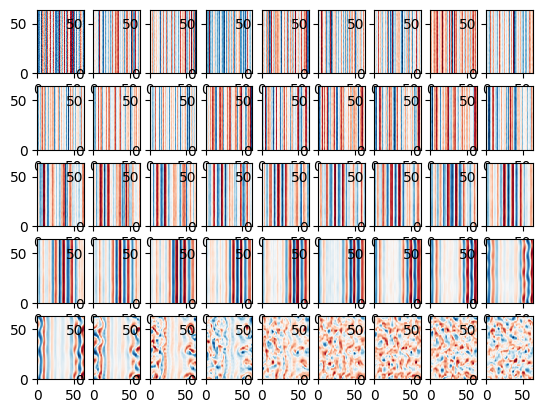

In [94]:
data = lowres_jet_data.q.isel(run=0, lev=0)
snapshots = [frame for frame in data.values]
num_train_frames = 45
total_frames = len(snapshots)
snapshots_train = snapshots[:num_train_frames]
snapshots_test = snapshots[num_train_frames:]
plt.set_cmap('RdBu')
for id_subplot, snapshot in enumerate(snapshots_train, start=1):
    plt.subplot(5, 9, id_subplot)
    plt.pcolor(snapshot)

## Dynamical Mode Decomposition using PyDMD

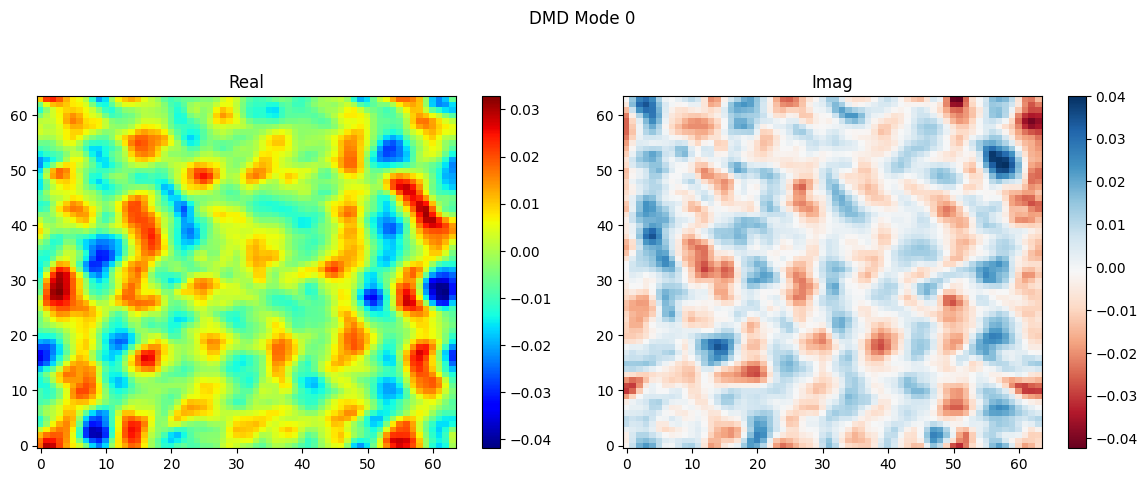

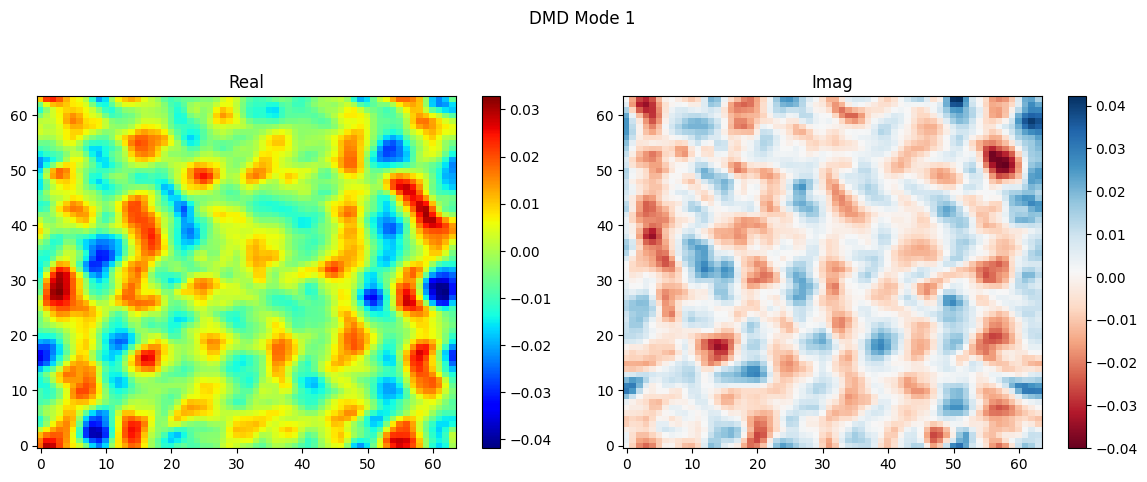

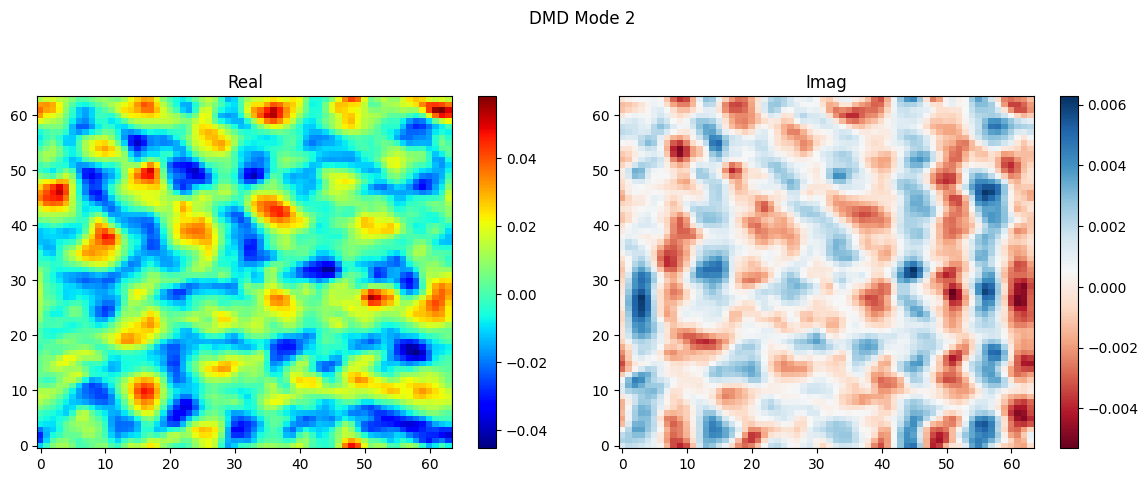

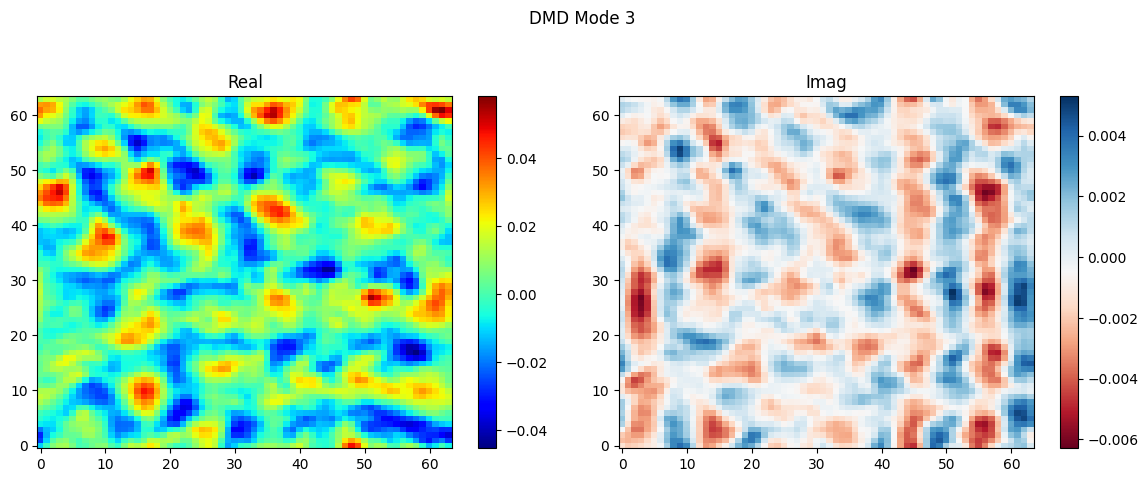

In [101]:
# PyDMD doesn't require us to flatten the spatial data
dmd = DMD(svd_rank=4, tlsq_rank=5, exact=True, opt=True)
dmd.fit(snapshots_train)
plot_modes_2D(dmd, figsize=(12, 5))

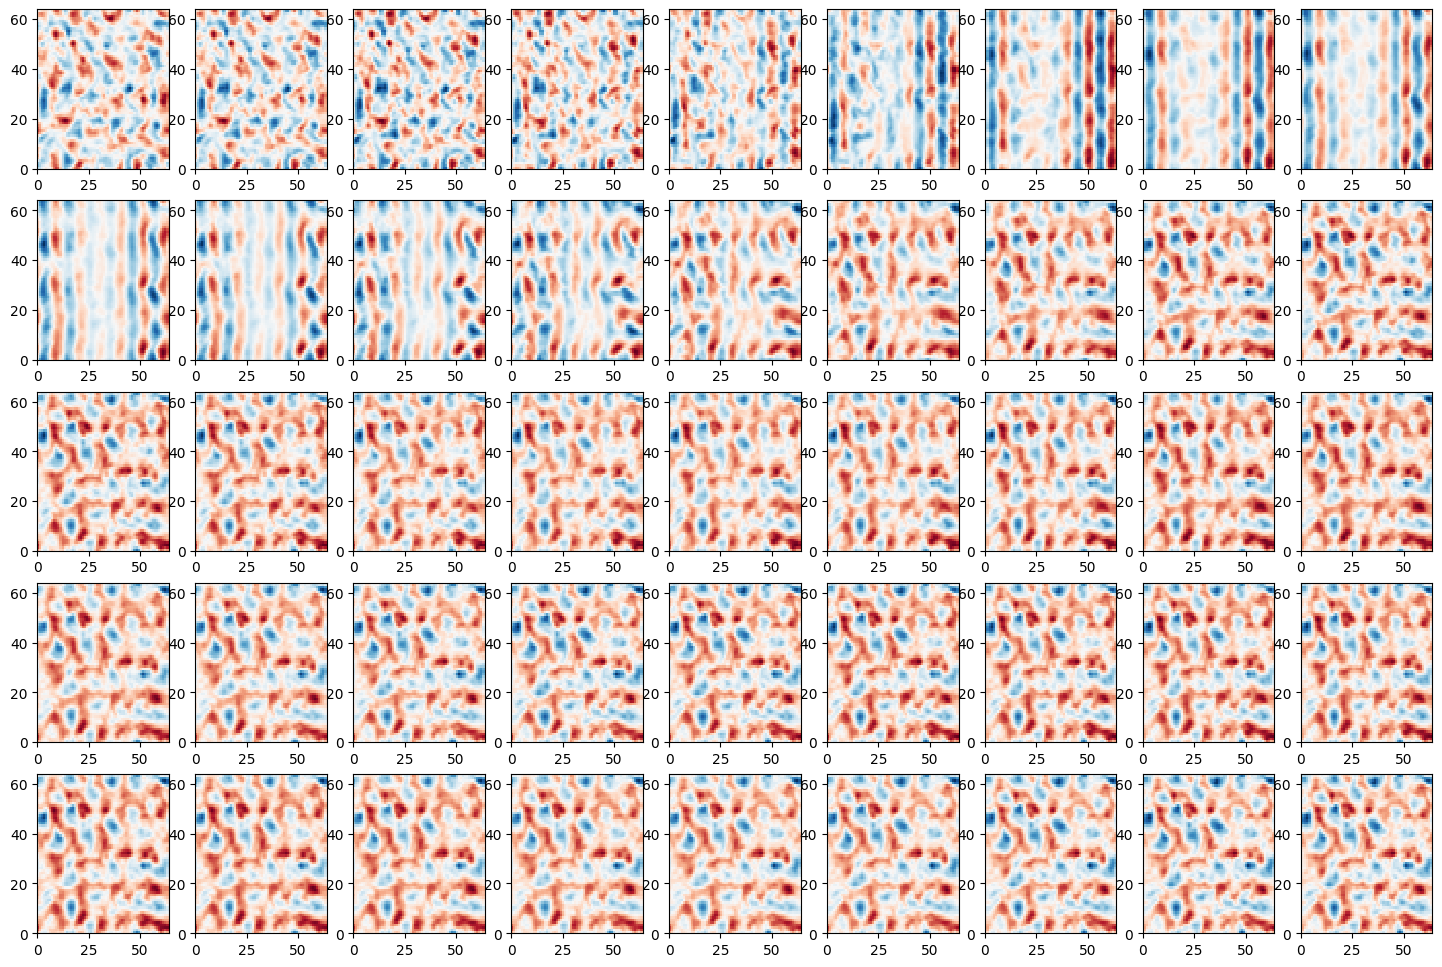

In [102]:
fig = plt.figure(figsize=(18, 12))
for id_subplot, snapshot in enumerate(dmd.reconstructed_data.T, start=1):
    plt.subplot(5, 9, id_subplot)
    plt.pcolor(snapshot.real.reshape(64, 64))

In [103]:
print(dmd.dmd_time)
dmd.dmd_time["dt"] = 1
dmd.dmd_time["tend"] = total_frames
print(dmd.dmd_time)

{'t0': 0, 'tend': 44, 'dt': 1}
{'t0': 0, 'tend': 87, 'dt': 1}


## DMD Prediction

Let's try to predict the test states using our DMD decomposition

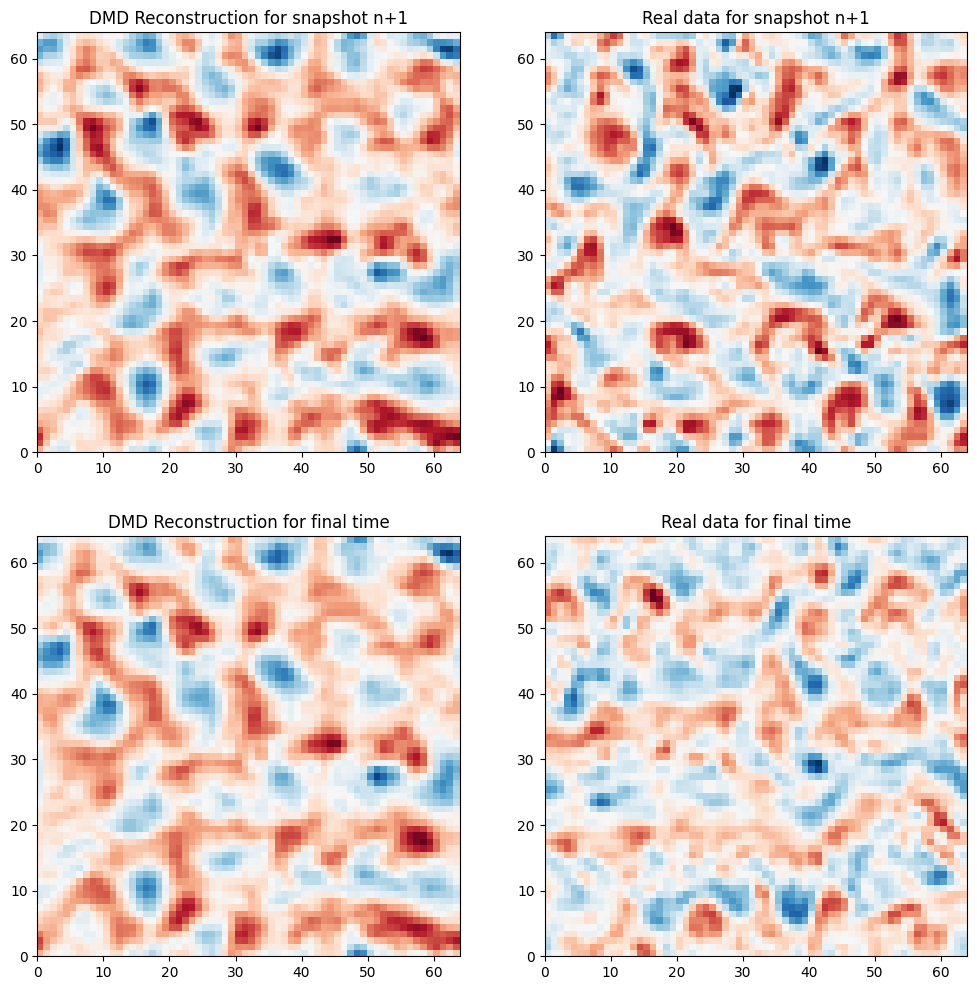

In [111]:
figure = plt.figure(figsize=(12, 12))
plt.subplot(2,2,1)
plt.title("DMD Reconstruction for snapshot n+1")
plt.pcolor(dmd.reconstructed_data.T[num_train_frames+1].reshape(64, 64).real)
plt.subplot(2,2,2)
plt.title("Real data for snapshot n+1")
plt.pcolor(snapshots_test[1])
plt.subplot(2,2,3)
plt.title("DMD Reconstruction for final time")
plt.pcolor(dmd.reconstructed_data.T[-1].reshape(64, 64).real)
plt.subplot(2,2,4)
plt.title("Real data for final time")
plt.pcolor(snapshots_test[-1])

In [100]:
len(dmd.reconstructed_data.T)

349